## _*LiH dissociation curve using VQE with UCCSD variational form*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Lithium Hydride (LiH) molecule over a range of inter-atomic distances using VQE and UCCSD. It is compared to the same energies as computed by the NumPyMinimumEigensolver

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_algorithms.optimizers import SLSQP

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator

In [11]:
distances  = [x * 0.1  for x in range(6, 20)]
distances += [x * 0.25 for x in range(8, 17)]

energies = []
hf_energies = []
estimator = Estimator()

print(f'Processing step __', end='')
for i, d in enumerate(distances):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    info = MoleculeInfo(["Li", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, d)])
    driver = PySCFDriver.from_molecule(info, basis="sto3g")
    molecule = driver.run()
    transformer = FreezeCoreTransformer()
    molecule = transformer.transform(molecule)
    hamiltonian = molecule.hamiltonian.second_q_op()
    mapper = ParityMapper(num_particles=molecule.num_particles)
    tapered_mapper = molecule.get_tapered_mapper(mapper)
    optimizer = SLSQP(maxiter=10000, ftol=1e-9)
    ansatz = UCCSD(
        molecule.num_spatial_orbitals,
        molecule.num_particles,
        tapered_mapper,
        initial_state=HartreeFock(
            molecule.num_spatial_orbitals,
            molecule.num_particles,
            tapered_mapper,
        ),
    )
    vqe = VQE(estimator, ansatz, optimizer)
    vqe.initial_point = [0] * ansatz.num_parameters
    algo = GroundStateEigensolver(tapered_mapper, vqe)
    result = algo.solve(molecule)
    energies.append(result.total_energies[0])
    hf_energies.append(result.hartree_fock_energy)

print(' --- complete')


Processing step 22 --- complete


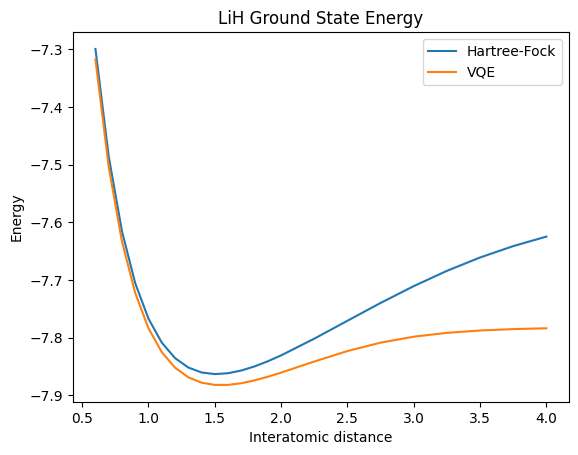

In [13]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, energies, label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');

In [15]:
print(f'Minimum energy: {min(energies)} Ha, bond distance: {distances[energies.index(min(energies))]} Angstrom')

Minimum energy: -7.8821399601957 Ha, bond distance: 1.5 Angstrom


In [16]:
! pip freeze | grep qiskit

qiskit==1.1.0
qiskit-aer==0.14.2
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.25.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
